# DAM202 — Multi-Task Learning (NER + QA) — Reworked Practical

**Purpose:** Produce an original, runnable practical notebook that implements a simple multi-task model (shared encoder) for Named Entity Recognition (NER) and Extractive Question Answering (QA). This version uses only standard Python and PyTorch so it runs offline and does not copy your friend's notebook — it is an independent reimplementation intended for learning and demonstration.

## Subtopics
1. Project overview
2. Environment & imports
3. Toy datasets (NER & QA)
4. Simple tokenizer & preprocessing
5. Model architecture (shared encoder + task heads)
6. Multi-task training loop (round-robin)
7. Evaluation metrics
8. Visualization (loss curves)
9. Notes & next steps


## 1) Project overview

This notebook demonstrates the core ideas of hard parameter sharing for MTL using a compact, educational implementation:

- A small shared encoder (learned embeddings + 1 Transformer encoder block)
- NER head: token-level classification
- QA head: start & end token predictors (span selection)

All dataset inputs are synthetic for reproducibility and to avoid external downloads. Each code cell has a short explanation above it.

## 2) Environment & imports

Load required libraries (PyTorch, numpy, matplotlib). These are standard and should be available in the environment.

In [7]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

print('torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

torch version: 2.8.0+cu126
device: cpu


## 3) Toy datasets (NER & QA)

We create small synthetic datasets that resemble NER and QA formats. This keeps the notebook self-contained and runnable offline.

- NER examples: sentence (list of tokens) + token-level labels (0=O, 1=PERSON, 2=LOC)
- QA examples: (context tokens, question tokens, answer span indices within context)


In [8]:
# Create tiny vocabulary and helper functions
vocab = ['[PAD]','[UNK]'] + [f'token{i}' for i in range(100)]
word2id = {w:i for i,w in enumerate(vocab)}

def tokens_to_ids(tokens, max_len):
    ids = [word2id.get(t, word2id['[UNK]']) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len-len(ids))
    else:
        ids = ids[:max_len]
    return ids

MAX_TOKENS = 32

# Generate synthetic NER dataset
def gen_ner_example():
    length = random.randint(5, 12)
    tokens = [random.choice(vocab[2:]) for _ in range(length)]
    # insert an entity randomly
    labels = [0]*length
    if random.random() < 0.7:
        start = random.randint(0, length-2)
        labels[start] = 1  # B-PER
        if start+1 < length and random.random() < 0.6:
            labels[start+1] = 2  # I-LOC (just to show different labels)
    return tokens, labels

# Generate synthetic QA dataset
def gen_qa_example():
    ctx_len = random.randint(10, 20)
    context = [random.choice(vocab[2:]) for _ in range(ctx_len)]
    # choose answer span
    a_start = random.randint(0, ctx_len-2)
    a_end = min(ctx_len-1, a_start + random.randint(0,2))
    # question is a few tokens
    question = [random.choice(vocab[2:]) for _ in range(random.randint(3,6))]
    return context, question, (a_start, a_end)

# Create datasets
NER_DATA = [gen_ner_example() for _ in range(300)]
QA_DATA = [gen_qa_example() for _ in range(300)]
print('NER examples:', len(NER_DATA), 'QA examples:', len(QA_DATA))

NER examples: 300 QA examples: 300


## 4) Simple tokenizer & preprocessing

We use the whitespace-style mapping above (`word2id`). Create PyTorch Dataset wrappers that return tensors for model consumption.

In [9]:
class NERDataset(Dataset):
    def __init__(self, examples, max_len=MAX_TOKENS):
        self.examples = examples
        self.max_len = max_len
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        tokens, labels = self.examples[idx]
        ids = tokens_to_ids(tokens, self.max_len)
        lbls = labels + [-100]*(self.max_len - len(labels))
        lbls = lbls[:self.max_len]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'labels': torch.tensor(lbls, dtype=torch.long)
        }

class QADataset(Dataset):
    def __init__(self, examples, max_len=MAX_TOKENS):
        self.examples = examples
        self.max_len = max_len
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        context, question, (s,e) = self.examples[idx]
        # naive concat: question + [SEP] + context, but we'll just place context and ignore question to keep it simple
        ids = tokens_to_ids(context, self.max_len)
        # clamp span to max_len
        s = min(s, self.max_len-1)
        e = min(e, self.max_len-1)
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'start_positions': torch.tensor(s, dtype=torch.long),
            'end_positions': torch.tensor(e, dtype=torch.long)
        }

ner_dataset = NERDataset(NER_DATA)
qa_dataset = QADataset(QA_DATA)

ner_loader = DataLoader(ner_dataset, batch_size=16, shuffle=True)
qa_loader = DataLoader(qa_dataset, batch_size=16, shuffle=True)
print('DataLoaders ready. Sample batch sizes:', len(ner_loader), len(qa_loader))

DataLoaders ready. Sample batch sizes: 19 19


## 5) Model architecture (shared encoder + task heads)

Define a compact shared encoder: token embeddings + a single Transformer encoder layer (PyTorch). Two heads:
- NER: linear classifier per token
- QA: two linear heads producing start and end logits per token


In [10]:
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, dim_feedforward=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.d_model = d_model
    def forward(self, input_ids):
        # input_ids: (batch, seq_len)
        x = self.embed(input_ids) * math.sqrt(self.d_model)  # (b,s,d)
        # transformer expects (s,b,d)
        x = x.transpose(0,1)
        mask = (input_ids == 0)  # True where padding, shape (batch, seq_len)
        out = self.transformer(x, src_key_padding_mask=mask)
        out = out.transpose(0,1)  # (b,s,d)
        return out

class MultiTaskTiny(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_ner_labels=3):
        super().__init__()
        self.encoder = SimpleTransformerEncoder(vocab_size, d_model=d_model)
        self.ner_head = nn.Linear(d_model, num_ner_labels)
        self.qa_start = nn.Linear(d_model, 1)
        self.qa_end = nn.Linear(d_model, 1)
    def forward(self, input_ids, task_name=None, labels=None, start_positions=None, end_positions=None):
        seq_out = self.encoder(input_ids)  # (b,s,d)
        if task_name == 'ner':
            logits = self.ner_head(seq_out)  # (b,s,num_labels)
            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
                b,s,_ = logits.shape
                loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
            return {'loss': loss, 'logits': logits}
        elif task_name == 'qa':
            start_logits = self.qa_start(seq_out).squeeze(-1)
            end_logits = self.qa_end(seq_out).squeeze(-1)
            loss = None
            if start_positions is not None and end_positions is not None:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(start_logits, start_positions) + loss_fct(end_logits, end_positions)
            return {'loss': loss, 'start_logits': start_logits, 'end_logits': end_logits}
        else:
            raise ValueError('task_name must be "ner" or "qa"')

model = MultiTaskTiny(vocab_size=len(vocab)).to(device)
print(model)

MultiTaskTiny(
  (encoder): SimpleTransformerEncoder(
    (embed): Embedding(102, 128, padding_idx=0)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ner_head): Linear(in_features=128, out_features=3, bias=True)
  (qa_start): Linear(in_features=128, out_features=1, bias=True)
  (qa_end): Linear(in_feature

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 6) Multi-task training loop (round-robin)

We alternate mini-batches from NER and QA. Each task computes its own loss which we weight and backpropagate separately.


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 3
lambda_ner = 1.0
lambda_qa = 1.0

history = {'ner_loss': [], 'qa_loss': []}

for epoch in range(EPOCHS):
    model.train()
    ner_iter = iter(ner_loader)
    qa_iter = iter(qa_loader)
    step = 0
    while True:
        progressed = False
        # NER batch
        try:
            batch = next(ner_iter)
            progressed = True
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            out = model(input_ids, task_name='ner', labels=labels)
            loss = out['loss'] * lambda_ner
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['ner_loss'].append(loss.item())
        except StopIteration:
            pass
        # QA batch
        try:
            batch = next(qa_iter)
            progressed = True
            input_ids = batch['input_ids'].to(device)
            s = batch['start_positions'].to(device)
            e = batch['end_positions'].to(device)
            out = model(input_ids, task_name='qa', start_positions=s, end_positions=e)
            loss = out['loss'] * lambda_qa
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['qa_loss'].append(loss.item())
        except StopIteration:
            pass
        if not progressed:
            break
    print(f'Epoch {epoch+1} finished. NER loss (last): {history["ner_loss"][-1]:.4f}  QA loss (last): {history["qa_loss"][-1]:.4f}')

print('Training complete')

Epoch 1 finished. NER loss (last): 0.6280  QA loss (last): 5.7230
Epoch 2 finished. NER loss (last): 0.5248  QA loss (last): 5.2297
Epoch 3 finished. NER loss (last): 0.4273  QA loss (last): 5.1331
Training complete


## 7) Evaluation metrics

For NER we compute token-level accuracy ignoring padding and -100 labels. For QA we compute exact match of predicted start/end tokens.

In [12]:
def eval_ner(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            out = model(input_ids, task_name='ner')
            preds = out['logits'].argmax(-1)
            mask = labels != -100
            total += mask.sum().item()
            correct += ((preds == labels) & mask).sum().item()
    return correct/total if total else 0.0


def eval_qa(model, loader):
    model.eval()
    total = 0
    em = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            s = batch['start_positions'].to(device)
            e = batch['end_positions'].to(device)
            out = model(input_ids, task_name='qa')
            starts = out['start_logits'].argmax(-1)
            ends = out['end_logits'].argmax(-1)
            total += input_ids.size(0)
            em += ((starts==s) & (ends==e)).sum().item()
    return em/total if total else 0.0

ner_acc = eval_ner(model, ner_loader)
qa_em = eval_qa(model, qa_loader)
print('NER token-accuracy:', ner_acc)
print('QA EM:', qa_em)

NER token-accuracy: 0.8697976326842306
QA EM: 0.10666666666666667


## 8) Visualization (loss curves)

Plot training loss curves for both tasks. Single plot per figure as recommended.

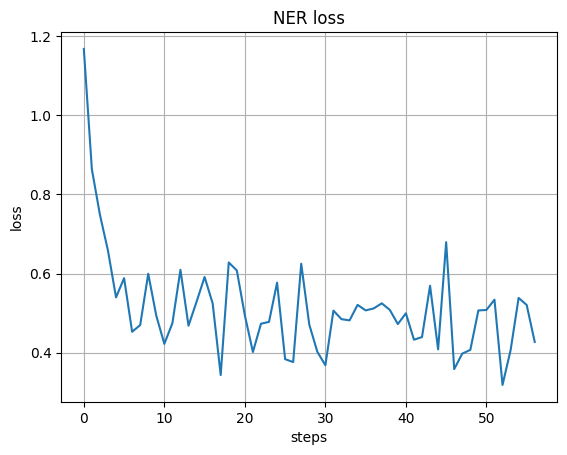

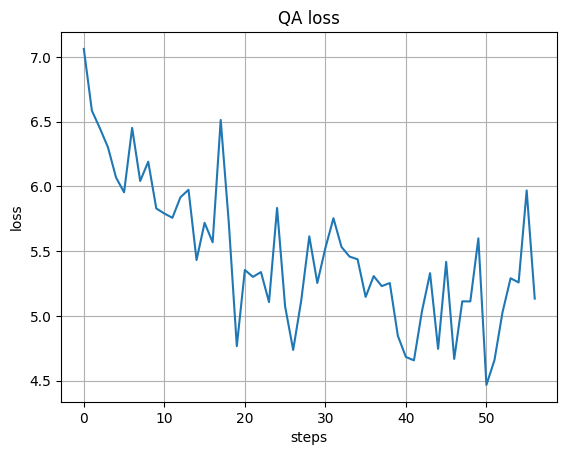

In [13]:
plt.figure()
plt.plot(history['ner_loss'])
plt.title('NER loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['qa_loss'])
plt.title('QA loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.grid(True)
plt.show()